<a href="https://colab.research.google.com/github/Evaggelou/Disaster-Response/blob/master/ML_Pipeline_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.


### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import numpy as np
import pandas as pd
import re
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive

# Import the Files from google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load data from database
engine = create_engine('sqlite:////content/drive/MyDrive/Udacity/DisasterResponse.db')
engine.table_names()

['Message']

In [4]:
df = pd.read_sql('SELECT * FROM Message', engine)
df.head()

,index,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
X = df.message
Y = df.loc[:, 'related':'direct_report']

print(X.shape)
print(Y.shape)

(26216,)
(26216, 36)


### 2. Write a tokenization function to process your text data

In [12]:
def tokenize(text):
    
    # Normalize text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize
    tokens = word_tokenize(text)
    
    # lematize & remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    text_lemmed = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words]
    
    # Find stems
    stemmer = PorterStemmer()
    text_stemmed = [stemmer.stem(word) for word in text_lemmed]

    return text_stemmed

In [13]:
i=100
print(X[i])
tokenize(X[i])

The message might be saying that they have been stuck in the presidential palace ( pal ) since the same Tuesday ( as the quake ). They need water. The message says they are not finding a little water. No names, no number of people given.


['messag',
 'might',
 'say',
 'stick',
 'presidenti',
 'palac',
 'pal',
 'sinc',
 'tuesday',
 'quak',
 'need',
 'water',
 'messag',
 'say',
 'find',
 'littl',
 'water',
 'name',
 'number',
 'peopl',
 'give']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


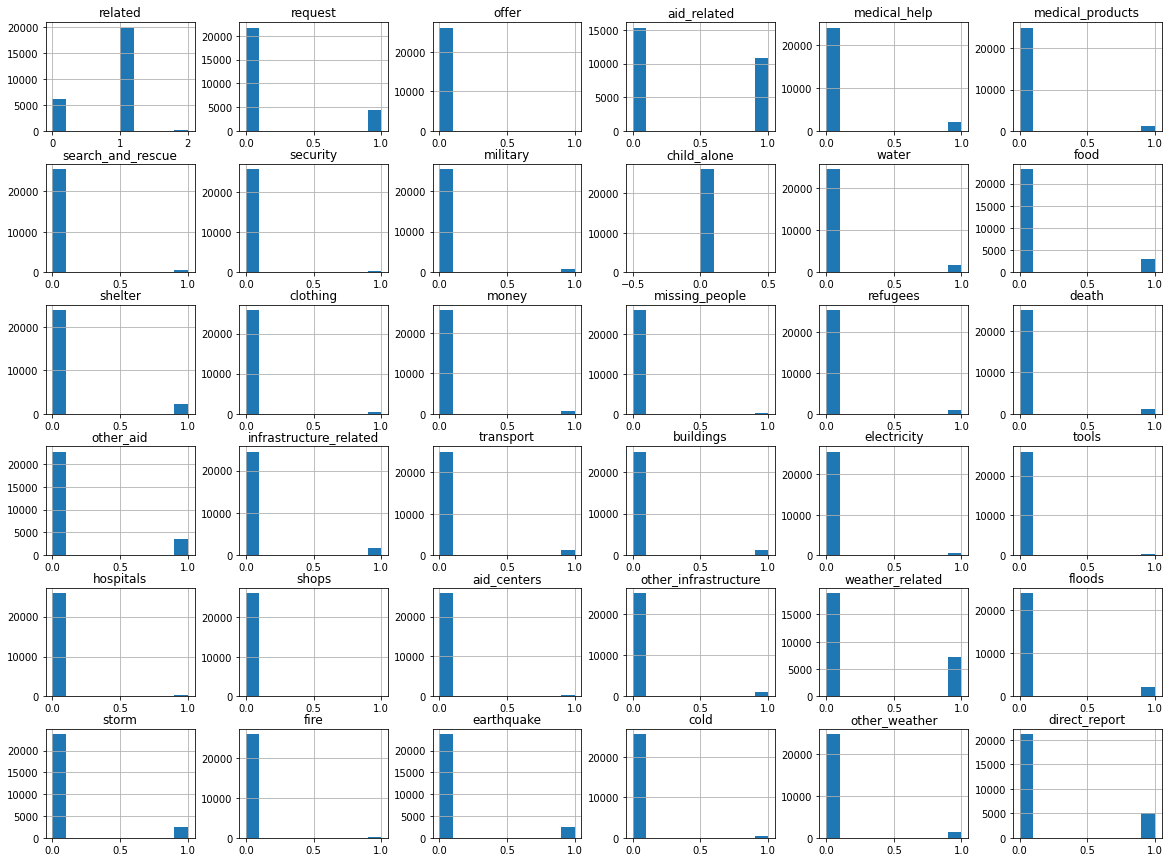

In [14]:
fig,ax = plt.subplots(figsize=(20,15))
Y.hist(ax=ax);

In [15]:
np.unique(Y["child_alone"])

array([0])

In [16]:
np.unique(Y["related"])

array([0, 1, 2])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 42)

In [18]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(AdaBoostClassifier()))
        ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x7f7825082730>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R'

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [20]:
y_pred = pipeline.predict(X_test)
y_pred

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [21]:
for i,col in enumerate(Y.columns):
    print(f"###################   {col}   ####################")
    print(classification_report(list(y_test.values[:, i]), list(y_pred[:, i])))

###################   related   ####################
              precision    recall  f1-score   support

           0       0.68      0.10      0.18      1563
           1       0.77      0.98      0.86      4944
           2       0.33      0.09      0.14        47

    accuracy                           0.77      6554
   macro avg       0.60      0.39      0.39      6554
weighted avg       0.75      0.77      0.70      6554

###################   request   ####################
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      5443
           1       0.77      0.50      0.61      1111

    accuracy                           0.89      6554
   macro avg       0.84      0.73      0.77      6554
weighted avg       0.88      0.89      0.88      6554

###################   offer   ####################
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00   

### 6. Improve your model
Use grid search to find better parameters. 

In [22]:
pipeline.get_params()

{'clf': MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                    base_estimator=None,
                                                    learning_rate=1.0,
                                                    n_estimators=50,
                                                    random_state=None),
                       n_jobs=None),
 'clf__estimator': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=50, random_state=None),
 'clf__estimator__algorithm': 'SAMME.R',
 'clf__estimator__base_estimator': None,
 'clf__estimator__learning_rate': 1.0,
 'clf__estimator__n_estimators': 50,
 'clf__estimator__random_state': None,
 'clf__n_jobs': None,
 'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=T

In [ ]:
# find the best parameters
parameters = {'tfidf__use_idf':[True, False],
              'clf__estimator__n_estimators':[50, 100, 200, 250],
              'clf__estimator__learning_rate':[0.5,1.0,1.5]}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters,verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] clf__estimator__learning_rate=0.5, clf__estimator__n_estimators=50, tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
# best estimator
cv.best_estimator_

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
y_pred = cv.predict(X_test)

for i,col in enumerate(Y.columns):
    print(f"###################   {col}   ####################")
    print(classification_report(list(y_test.values[:, i]), list(y_pred[:, i])))

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [ ]:
pickle.dump(cv, open('/content/drive/MyDrive/Udacity/model.pkl', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.